# General Linear Model - Frequency and Severity

## IN PROGRESS!!

In [73]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

## About the Dataset

In the two datasets freMTPL2freq and freMTPL2sev, risk features are collected for 677,991 motor third-party liability policies (observed mostly on one year), in addition to claim numbers by policy as well as their corresponding claim amounts. freMTPL2freq contains the risk features and claim counts, while freMTPL2sev contains claim amounts. Both tables can be linked together via the corresponding policy ID.

Dataset Details (Frequency)

* IDpol: The policy ID (used to link with the claims dataset).
* ClaimNb: The number of claims during the exposure period.
* Exposure: The period of exposure for a policy, in years.
* VehPower: The power of the car (split into ordinal categories).
* VehAge: The vehicle age, in years.
* DrivAge: The driver's age, in years (in France, people can drive a car from the age of 18).
* BonusMalus: The bonus/malus rating (no-claims reward rating) of the policyholder, between 50 and 350: <100 means bonus, >100 means malus in France.
* VehBrand: The brand of the car, divided into unknown categories.
* VehGas: The car's fuel type: Diesel or Regular (petrol?).
* Area: The density-rating of the community that the car driver lives in, divided into categories; from "A" - rural area to "F" - urban centre.
* Density: The density of inhabitants, in the city that the driver of the car lives in, in (number of inhabitants per km^2).
* Region: The policy region in France (based on the 1970-2015 region classification).

Dataset Details (Severe)

* IDpol: The policy ID (used to link with the claims dataset).
* ClaimAmount: The cost of the claim, seen as at a recent date (?).


Additional information can be found at http://cas.uqam.ca/pub/web/CASdatasets-manual.pdf.

Source: https://www.kaggle.com/datasets/karansarpal/fremtpl2-french-motor-tpl-insurance-claims

In [74]:
freq_data = pd.read_csv("data/freMTPL2freq.csv", index_col=0)
sev_data = pd.read_csv("data/freMTPL2sev.csv", index_col=0)

In [75]:
freq_data.head()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
IDpol,,,,,,,,,,,
1.0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
3.0,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
5.0,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
10.0,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
11.0,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine


In [76]:
sev_data.head()

,ClaimAmount
IDpol,
1552,995.20
1010996,1128.12
4024277,1851.11
4007252,1204.00
4046424,1204.00


# EDA - Data Exploration

In [77]:
freq_data.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [79]:
print(f"Unique Vehicle Brands: {freq_data.VehBrand.unique()}")
print(f"Unique Vehicle Gas: {freq_data.VehGas.unique()}")
print(f"Unique Areas: {freq_data.Area.unique()}")
print(f"Unique Regions: {freq_data.Region.unique()}")

Unique Vehicle Brands: ['B12' 'B6' 'B3' 'B2' 'B5' 'B10' 'B14' 'B13' 'B4' 'B1' 'B11']
Unique Vehicle Gas: ['Regular' 'Diesel']
Unique Areas: ['D' 'B' 'E' 'C' 'F' 'A']
Unique Regions: ['Rhone-Alpes' 'Picardie' 'Aquitaine' 'Nord-Pas-de-Calais'
 'Languedoc-Roussillon' 'Pays-de-la-Loire' "Provence-Alpes-Cotes-D'Azur"
 'Ile-de-France' 'Centre' 'Corse' 'Auvergne' 'Poitou-Charentes'
 'Bourgogne' 'Bretagne' 'Midi-Pyrenees' 'Alsace' 'Basse-Normandie'
 'Champagne-Ardenne' 'Franche-Comte' 'Limousin' 'Haute-Normandie']


### Encoding categorical features

In [80]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [81]:
def encode_categorical_features(x, type="label"):

    if type == "label":
        enc = LabelEncoder()
    else:
        enc = OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F"]])

    return enc.fit_transform(x)

In [82]:
freq_data.VehBrand = encode_categorical_features(freq_data.VehBrand, type="label")
freq_data.VehGas = encode_categorical_features(freq_data.VehGas, type="label")
freq_data.Area = encode_categorical_features(freq_data[["Area"]], type="ordinal")
freq_data.Region = encode_categorical_features(freq_data.Region, type="label")

In [83]:
freq_data.head()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
IDpol,,,,,,,,,,,
1.0,1,0.10,5,0,55,50,3,1,3.0,1217,20
3.0,1,0.77,5,0,55,50,3,1,3.0,1217,20
5.0,1,0.75,6,2,52,50,3,0,1.0,54,17
10.0,1,0.09,7,0,46,50,3,0,1.0,76,1
11.0,1,0.84,7,0,46,50,3,0,1.0,76,1


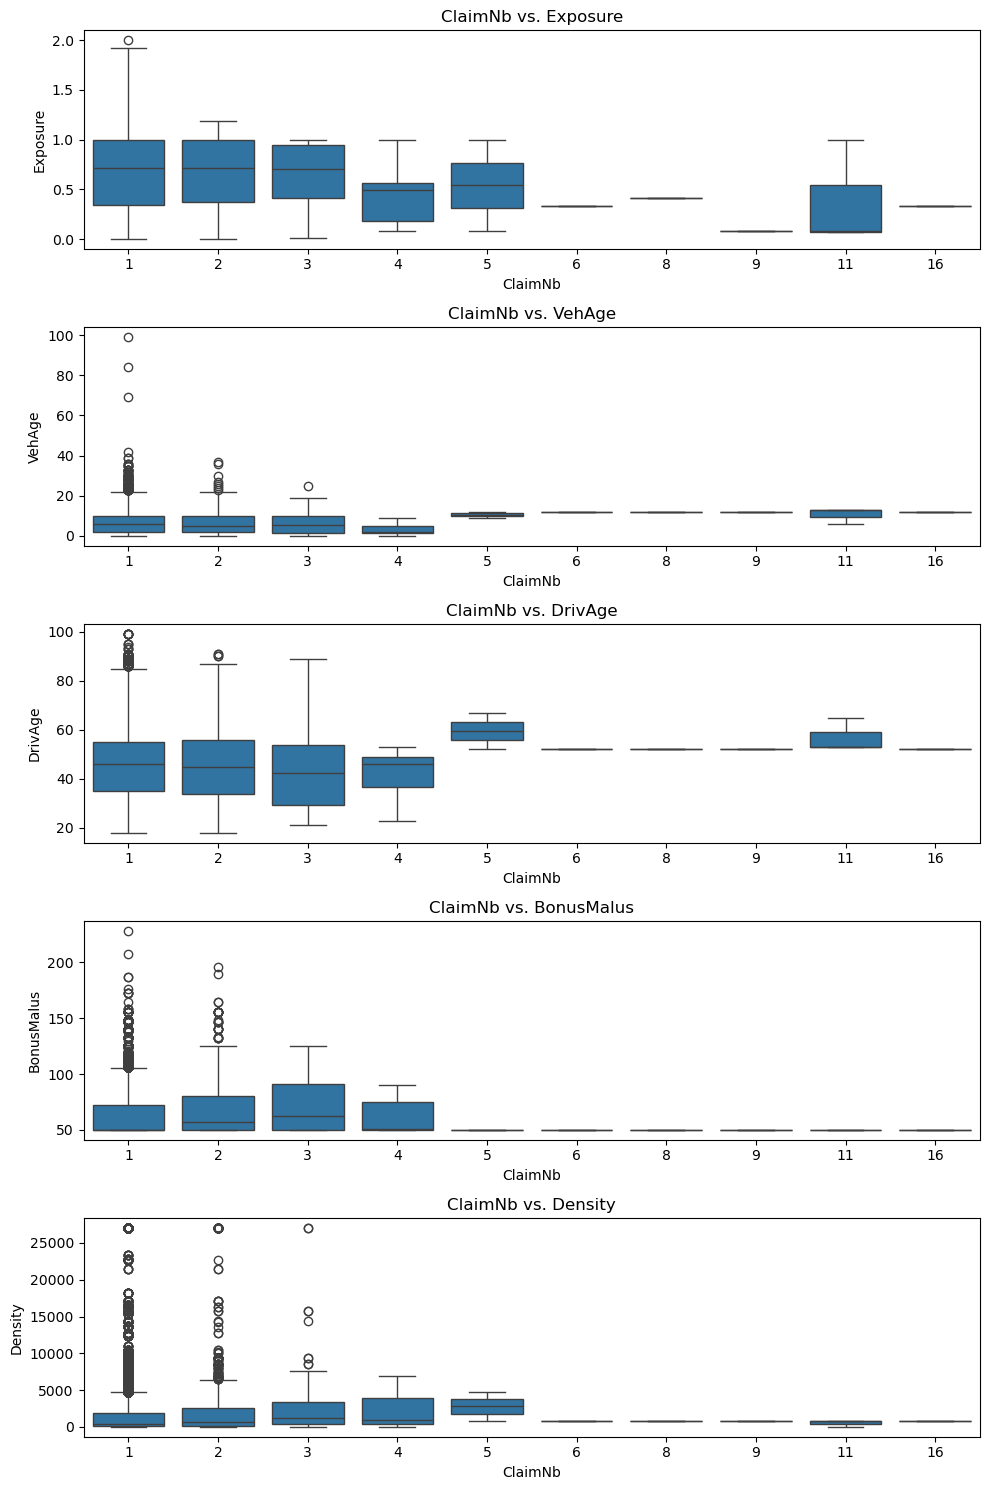

In [108]:
# Numericals 
# Exposure, VehAge, DrivAge, BonusMalus, Density

## Only on ClaimNb > 0 cases

freq_data_with_claim = freq_data[freq_data.ClaimNb > 0]

numericals = ["Exposure", "VehAge", "DrivAge", "BonusMalus", "Density"]

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

axs = axs.flatten()

for idx, ax in enumerate(axs):
    sns.boxplot(data=freq_data_with_claim, x='ClaimNb', y=numericals[idx], ax=ax, showfliers=True)
    ax.set_title(f"ClaimNb vs. {numericals[idx]}")

plt.tight_layout()
plt.show()
    

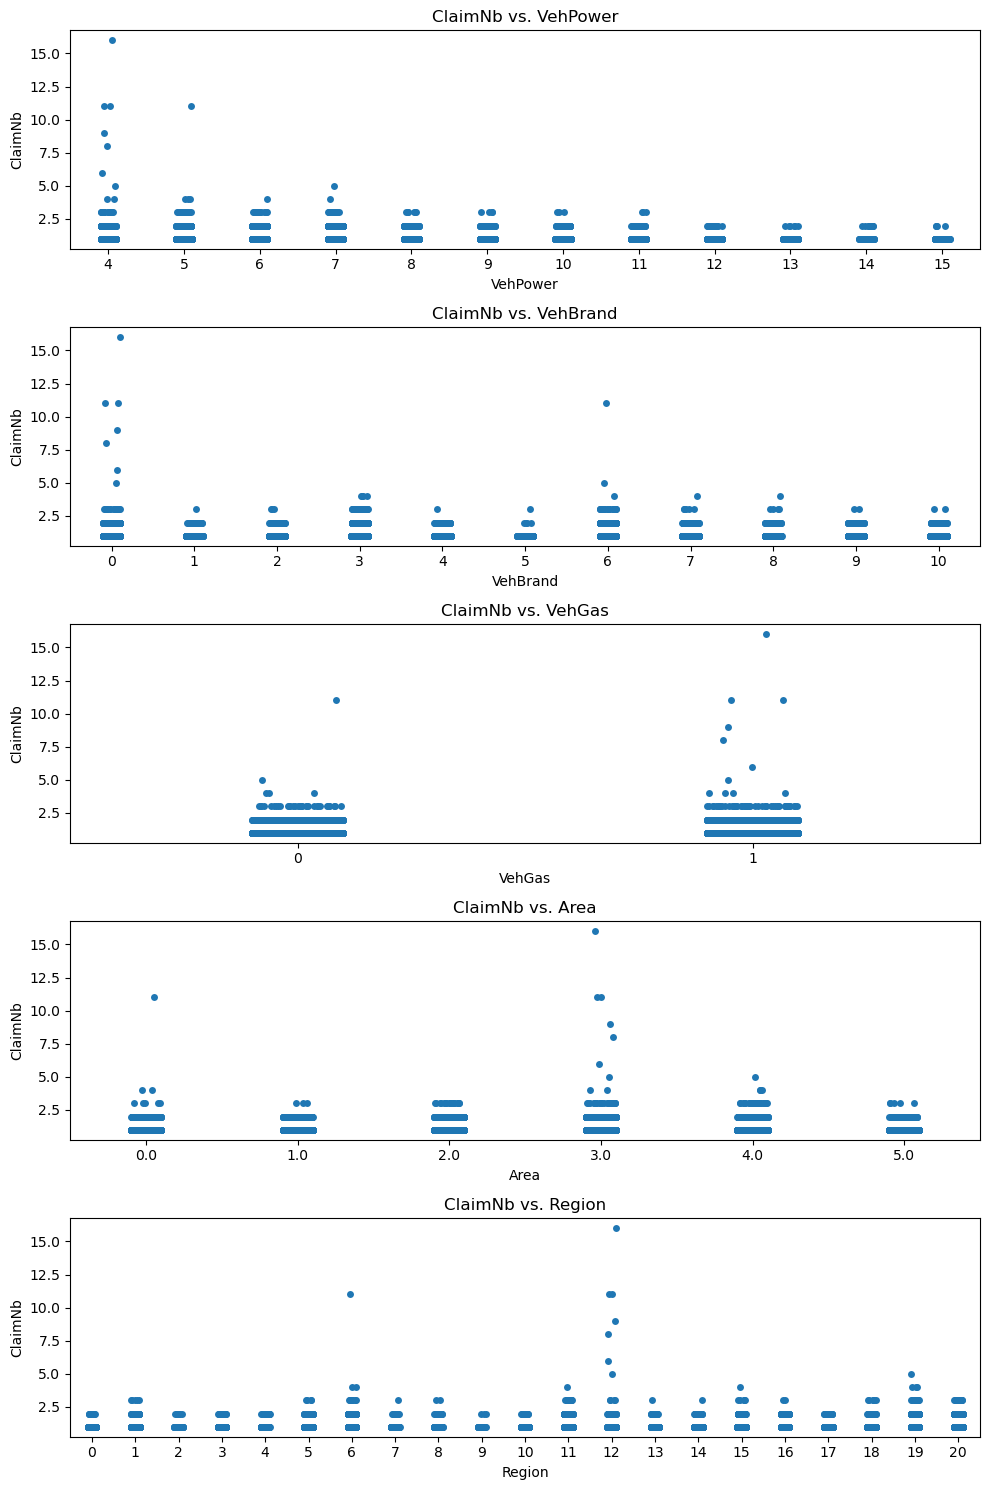

In [114]:
# Categoricals
# VehPower, VehBrand, VehGas, Area, Region

## Only on ClaimNb > 0 cases

categoricals = ["VehPower", "VehBrand", "VehGas", "Area", "Region"]

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 15))

axs = axs.flatten()

for idx, ax in enumerate(axs):
    sns.stripplot(data=freq_data_with_claim, x=categoricals[idx], y='ClaimNb', ax=ax, orient="v")
    ax.set_title(f"ClaimNb vs. {categoricals[idx]}")

plt.tight_layout()
plt.show()
    

## Frequency

In [147]:
endog = freq_data.ClaimNb
exog = freq_data.drop("ClaimNb", axis=1)
exog = sm.add_constant(exog)

In [148]:
model_freq = sm.GLM(endog, exog, family=sm.families.Poisson())

In [149]:
model_freq_results = model_freq.fit()

In [150]:
print(model_freq_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   678011
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4333e+05
Date:                Thu, 02 Jan 2025   Deviance:                   2.1734e+05
Time:                        14:22:59   Pearson chi2:                 7.35e+05
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0005315
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8094      0.008   -341.008      0.0

## Header Information

1. **Dep. Variable:** This is the dependent (outcome) variable in your model. Here, it is `frequency`, representing how many events occur in each time period.

2. **No. Observations:** The total number of data points used in the model. In this case, 24 observations (e.g., 24 months).

3. **Model:** Indicates that you’re using a Generalized Linear Model (GLM).

4. **Model Family:** Here, it’s `Poisson`, which is commonly used for count data.

5. **Link Function:** `Log`. This transforms the mean of the Poisson distribution into a linear function of predictors: \(\log(\lambda) = \beta_0 + \beta_1 X_1 + \dots\).

6. **Df Residuals:** Degrees of freedom for residuals. Computed as (Number of Observations) − (Number of Parameters).

7. **Df Model:** Number of predictors (excluding the intercept). There are 2 predictors in this example.

8. **Scale:** For Poisson GLMs, the scale is typically fixed to 1, given how variance relates to the mean.

9. **Method:** IRLS (Iteratively Reweighted Least Squares), the algorithm used to estimate the parameters.

10. **Log-Likelihood:** The log of the likelihood function at the fitted parameters. Less negative values usually indicate a better fit.

11. **Deviance:** A goodness-of-fit measure. Lower deviance implies a better fit relative to a saturated model.

12. **Pearson chi2:** Another goodness-of-fit measure. Values close to the degrees of freedom suggest a reasonable model fit.

13. **No. Iterations:** The count of IRLS iterations taken to converge.

14. **Pseudo R-squ. (CS):** A pseudo-\(R^2\) measure (Cox–Snell or similar). Not the same as linear regression’s \(R^2\), but higher values generally indicate more variance explained.

15. **Covariance Type:** `nonrobust` here means standard (classical) variance-covariance estimation for the parameter errors.


## Coefficient Table

- **coef (Coefficient)**: The estimated effect of each predictor on the log of the expected count (for a Poisson model).  
- **std err (Standard Error)**: Indicates the precision of the coefficient estimate.  
- **z**: The coefficient divided by its standard error, indicating how many standard deviations the estimate is from zero.  
- **P>|z|**: The p-value for testing if the true coefficient is zero. Lower values suggest statistical significance.  
- **[0.025  0.975]**: The 95% confidence interval for the coefficient; if it excludes zero, the effect is significant at the 5% level.


## Practical Interpretation
1. **Intercept (1.3570)**:

The baseline log-frequency (1.3570) corresponds to
exp(1.3570)≈3.89 expected events per unit time when (active_customers / 1000) = 0 and security_measure = 0.
It serves as a reference point.

2. **Active Customers / 1000 (0.1545)**:

For every additional 1000 active customers, you expect your fraud count (or event frequency) to multiply by about 1.167 (= exp(0.1545)).
This implies that bigger business volume is associated with higher event counts.

3. **Security Measure (-0.4993)**:

Having the security measure “turned on” reduces the expected event count by about 39% (1-exp(-0.4993)).
Statistically significant (p=0.001), suggesting a real effect in reducing fraud frequency.

## Severity

In [130]:
sev_data = freq_data.merge(sev_data, left_index=True, right_index=True)

In [141]:
endog = sev_data.ClaimAmount
exog = sev_data.drop(["ClaimNb", "ClaimAmount"], axis=1)
exog = sm.add_constant(exog)

In [ ]:
link = sm.genmod.families.links.Log()

gamma_model = sm.GLM(endog, exog, family=sm.families.Gamma(link=link)).fit()
print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26433
Model Family:                   Gamma   Df Model:                           10
Link Function:                    Log   Scale:                          57.151
Method:                          IRLS   Log-Likelihood:            -2.9048e+05
Date:                Thu, 02 Jan 2025   Deviance:                       42585.
Time:                        14:20:40   Pearson chi2:                 1.51e+06
No. Iterations:                    24   Pseudo R-squ. (CS):           0.002576
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6435      0.373     20.513      0.0

### Overall Interpretation

- The model indicates that **active_customers** has a notable, positive relationship with monthly losses. Each 1000 additional customers increases expected losses by roughly 50% on a multiplicative scale.  
- The **security_measure** predictor does not appear to affect severity, given its near-zero coefficient and non-significant p-value. This might mean, for example, that while a security measure may reduce the *frequency* of fraud, it does not change the *average severity* when fraud does occur.  
- The model fit statistics (deviance, Pearson chi-square) do not show major red flags, and the scale parameter is reasonable for a Gamma distribution. However, a pseudo-\(R^2\) around 0.18 suggests there could be unexplained variability—possibly additional factors would further improve the model.

Overall, these results highlight how **frequency** and **severity** can be modeled separately: frequency might be more affected by the security measure, while severity scales mostly with business volume in this dataset.
